# Creating profiles of the ditricts

In [1]:
import numpy as np
import pandas as pd
import os
 
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
from sklearn.mixture import GaussianMixture 

import seaborn as sns
import matplotlib.pyplot as plt

import os
os.chdir(os.getcwd())

## I. Data preprocessing

### 1. Load data

In [115]:
# Import basic dataset
data = pd.read_excel('District demographics 2014.xls', sheetname = 'List_1')

# Extended dataset with enterprises
# data = pd.read_excel('New Data Sets\District Demographics 2014.xls', sheetname = 'List_5')

In [116]:
# Create a dataframe
df = pd.DataFrame(data = data)

# Filling NaNs with zeors
df = df.fillna(0)

# Remember the names of the distrcits
district_names = df.index

### 2. Standatrization

In [117]:
# Standardizing population data
delimiter = df['Number of residents']
for i in range(1, 22):
    df[df.columns[i]] = df[df.columns[i]] / delimiter

# Standardizing household data
delimiter = df['Number of households']
for i in range(23, 31):
    df[df.columns[i]] = df[df.columns[i]] / delimiter
    
# Standardizing enterprises data
# delimiter = df['Number of offices']
# for i in range(33,52):
#     df[df.columns[i]] = df[df.columns[i]] / delimiter

In [118]:
# Dropping out irrelevant columns
df = df.drop(['Number of residents', 'Number of households'], axis = 1)
# df = df.drop(['Number of residents', 'Number of households', 'Number of offices'], axis = 1)
df = df.drop(['01 Oostduinen'], axis = 0)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)

# Obtaining names for further plotting
feature_names = df.index
factor_names =  df.columns

### 3. Rescale data

In [119]:
# Probably, we can consider only results obtained by using MinMaxScaler and MaxAbsScaler
# in theses cases reults makes sense

# Scale values from 0 to 1
# Scaling happens by column wise
scaler = MinMaxScaler(feature_range = (0, 1))
df = scaler.fit_transform(df)

# Scale each feature by its maximum absolute value.
# scaler = MaxAbsScaler()
# df = scaler.fit_transform(df)

# Robust scaler
# scaler = RobustScaler()
# df = scaler.fit_transform(df)

# Normalizer
# Normalization happens by row 
# scaler = Normalizer()
# df = scaler.fit_transform(df)

### 4. Exploring data with PCA

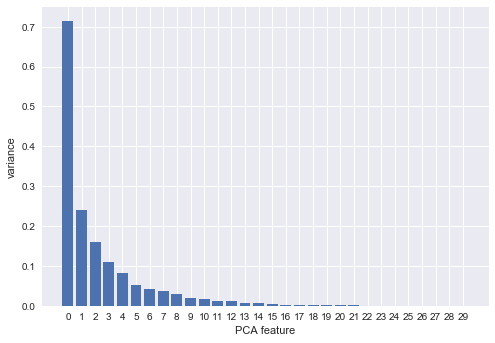

In [120]:
# 
pca = PCA()

# Fit the data to the model
pca.fit(df)

# Plot the explained variances
features = range(pca.n_components_)
features
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

### 5. Apply NMF

In [121]:
n_components = 7
model = NMF(n_components = n_components)
model.fit(df)
nmf_features = model.transform(df)
components = model.components_

W = nmf_features
H = components

W_df = pd.DataFrame(index = feature_names, columns = list(range(0, n_components)))
H_df = pd.DataFrame(index = list(range(0, n_components)) , columns = factor_names)

W_df.loc[:,:] = W
H_df.loc[:,:] = H

### 6. Plot clustermaps before standardization

D:\Anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


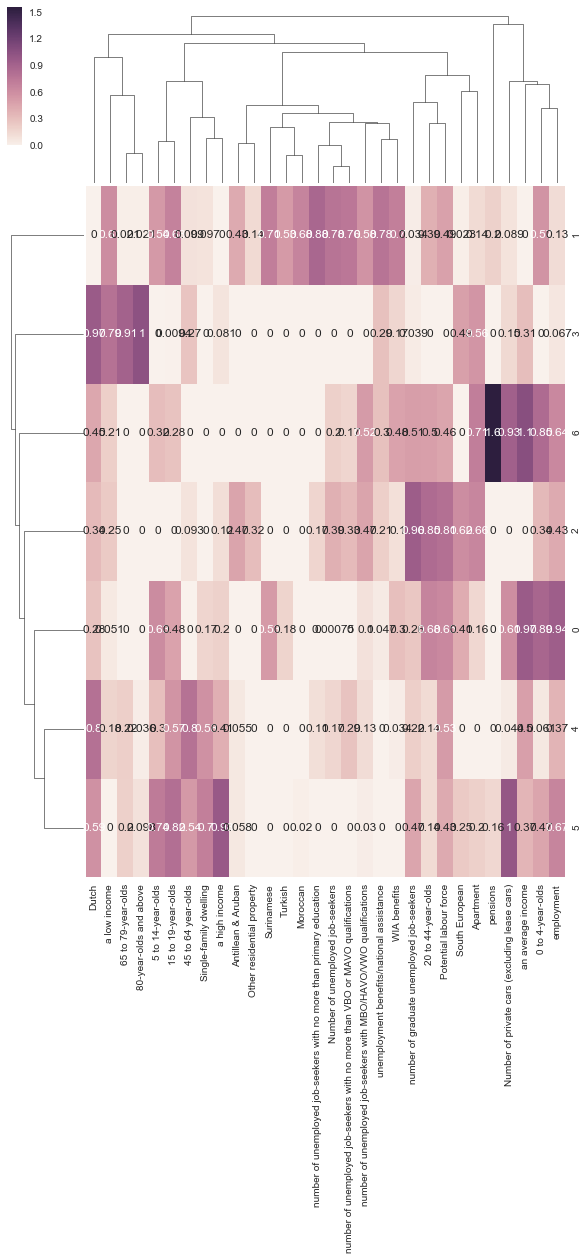

In [126]:
# Components - properties
sns.clustermap(H_df, figsize = [10,16], annot = True)
plt.show()

D:\Anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


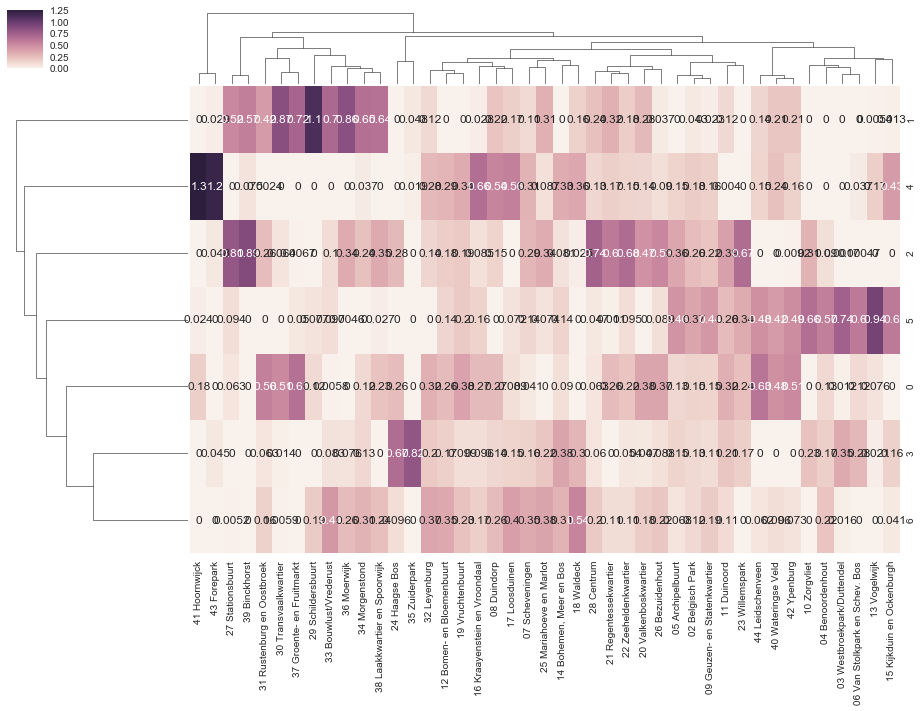

In [10]:
# Features - districts
sns.clustermap(W_df.T, figsize = [16, 10], annot = True)
plt.show()

### 7. Second itertaion of standardization

In [11]:
# # Reshaping the data between 0 and 1
# W_df['Total'] =  W_df.apply(lambda x: x.sum(), axis = 1)
# W_df = W_df.iloc[:,0:7].div(W_df.Total, axis = 0).fillna(0)
# # Check the results
# # W_df.apply(lambda x: x.sum(), axis = 1)

# H_df.loc['Total'] =  H_df.apply(lambda x: x.sum(), axis = 0)
# H_df = H_df.iloc[:,0:29].div(H_df.loc['Total'], axis = 1).fillna(0)
# H_df = H_df.drop(['Total'])
# # Check the results
# # H_df.apply(lambda x: x.sum(), axis = 0)

### 8. Identify number of clusters using K-means and inertia values

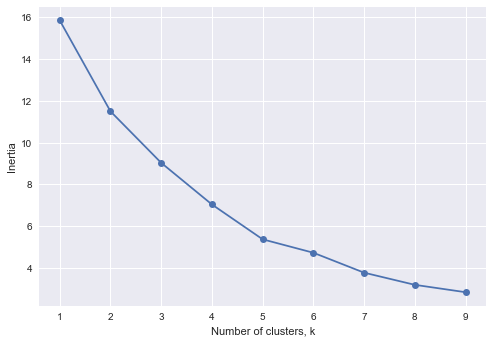

In [12]:
# 
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters = k)
    
    # Fit model to samples
    model.fit(W_df)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('Number of clusters, k')
plt.ylabel('Inertia')
plt.xticks(ks)
plt.show()

### 9. Cluster districts based on demographic profiles

In [13]:
model = KMeans(n_clusters = 7)
W_df['Cluster'] = model.fit_predict(W_df)

## II. Plotting results on map

In [14]:
# Uploading necessary packages
import fiona
import matplotlib.pyplot as plt
import bokeh
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool
output_notebook()
# from bokeh.plotting import *
import shapefile
from shapely.geometry import shape
import geopandas as gpd 

from bokeh.plotting import figure

Loading BokehJS ...

In [15]:
# # The idea is to get coordinates of the districts and put there piecharts
geo_df = gpd.read_file('Wijkgrenzen_Den_Haag/Wijkgrenzen_Den_Haag.shp')

# # Get the centers of the districts
centers = geo_df.centroid

In [16]:
# # Get coordinates of district boundaries
# shape_file = fiona.open('Wijkgrenzen_Den_Haag/Wijkgrenzen_Den_Haag.shp')

# # Get the next item (district) 
# Leidschenveen = shape_file.next()

# # Get district name
# # Leidschenveen['properties']['WIJKNAAM']

# # Plot the shape
# shape(Leidschenveen['geometry'])

# # Get the bounds
# # shape(Leidschenveen['geometry']).bounds

# # Get first pair of coordinates
# # Leidschenveen['geometry']['coordinates'][0][0]

In [17]:
# Another way to process the data
sh = shapefile.Reader('Wijkgrenzen_Den_Haag/Wijkgrenzen_Den_Haag.shp')

# Get shapefile records 
sh_recs = sh.records()

# 
district_names = list()

# Get the names in the order that they stored
for i in range(len(sh_recs)):
    district_names.append(sh_recs[i][2])

# Get the coordinates
district_coors = [s.points for s in sh.shapes()]

lons_combined = np.empty((44, 0)).tolist()
lats_combined = np.empty((44, 0)).tolist() 
for i in range(len(district_coors)):
    for j in range(len(district_coors[i])):
        lons_combined[i].append(district_coors[i][j][0])
        lats_combined[i].append(district_coors[i][j][1])

In [18]:
from bokeh.io import show
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper, LinearColorMapper
from bokeh.palettes import Plasma6 as palette
from bokeh.plotting import figure

# palette = ['#CC3300', '#CF3C09',  '#D14411',  '#D44D1A',  '#D65523', '#D95E2B', '#DB6634',  
#            '#DE6F3D',  '#E07745',  '#E3804E',  '#E68856',  '#E8915F', '#EB9A68',  '#EDA270', 
#            '#F0AB79',  '#F2B382',  '#F5BC8A',  '#F7C493',  '#FACD9C',  '#FCD5A4',  '#FFDEAD']

palette = palette
palette.reverse()

color_mapper = LinearColorMapper(palette=palette)

source = ColumnDataSource(data=dict(
    x = lons_combined,
    y = lats_combined,
    name = district_names,
    cluster = W_df['Cluster'],
))

TOOLS = "pan, wheel_zoom, reset, hover, save"

p = figure(
    title = "Den Haag, ...", tools = TOOLS,
    x_axis_location = None, y_axis_location = None
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
          fill_color={'field': 'cluster', 'transform': color_mapper},
          fill_alpha=0.9, line_color="white", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("District", "@name"),
    ("Cluster number", "@cluster")
#     ("(Long, Lat)", "($x, $y)"),
]
show(p)

D:\Anaconda\lib\site-packages\bokeh\models\sources.py:89: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))


In [19]:
source = ColumnDataSource(data=dict(
    x = lons_combined,
    y = lats_combined,
    name = district_names
))

TOOLS = "pan, wheel_zoom, reset, hover, save"

p = figure(
    title = "Den Haag", tools = TOOLS,
    x_axis_location = None, y_axis_location = None
)

p.grid.grid_line_color = None

p.patches('x', 'y', source=source,
#          fill_color={'field': 'population', 'transform': color_mapper},
#          fill_color={'transform': color_mapper},
          fill_color = 'lightsteelblue', 
          fill_alpha=1, line_color="black", line_width=0.5)

hover = p.select_one(HoverTool)
hover.point_policy = "follow_mouse"
hover.tooltips = [
    ("Name", "@name")
#     ("Population of the district", "@population")
#     ("(Long, Lat)", "($x, $y)"),
]


# define starts/ends for wedges from percentages of a circle
percents = [0, 0.3, 0.4, 0.6, 0.9, 1]
starts = [p*2*np.pi for p in percents[:-1]]
ends = [p*2*np.pi for p in percents[1:]]

# a color for each pie piece
colors = ["red", "green", "blue", "orange", "yellow"]

n = len(district_names)
i = 0
for i in range(0, n) : 
    p.wedge(x=centers.x[i], y=centers.y[i], radius=0.0035, start_angle=starts, end_angle=ends, color=colors)

show(p, notebook_handle=True)

# Creating voting profiles

# I. Data preprocessing

## 1. Load data

In [20]:
# Read csv file
voting_data ='Voting 2014.csv'

# Convert csv to dataframe
df_voting  = pd.read_csv(voting_data, index_col = None, header = 0)
df_voting = df_voting.set_index('Wijken')

In [21]:
# df_voting.head()
# The following districts have zeros in their voting data
# '01 Oostduinen'
# '24 Haagse Bos'
# '35 Zuiderpark'
# '43 Forepark'

In [22]:
# Calculate the sum for each district
df_voting['Total'] =  df_voting.apply(lambda x: x.sum(), axis = 1)

# Fill NaNs
df_voting = df_voting.fillna(0)

print('Number of districts in the dataset:', len(df_voting))
print('Number of political parties:', len(df_voting.columns) - 1)

Number of districts in the dataset: 44
Number of political parties: 19


## 2. Standartization

In [23]:
# Standartize the voting based on its value divided by total value
df_voting = df_voting.loc[:,'PvdA':'TerLin'].div(df_voting['Total'], axis = 0).fillna(0)

## 3. Apply NMF

In [24]:
# Fit dataframe into NMF 
n_components = 7

model = NMF(n_components = n_components)
model.fit(df_voting)
nmf_features = model.transform(df_voting)
components = model.components_

W = nmf_features
H = components

district_names = df_voting.index
variable_names = df_voting.columns

W_df_voting = pd.DataFrame(index = district_names, columns = list(range(0, n_components)))
H_df_voting = pd.DataFrame(index =  list(range(0, n_components)) , columns = variable_names)

# fit the dataframe with its coresponding name
W_df_voting.loc[:,:] = W
H_df_voting.loc[:,:] = H

In [25]:
# W_df_voting['Total'] =  W_df_voting.apply(lambda x: x.sum(), axis = 1)
# W_df_voting = W_df_voting.iloc[:,0:7].div(W_df_voting.Total, axis = 0) .fillna(0)

# H_df_voting['Total'] =  H_df_voting.apply(lambda x: x.sum(), axis = 1)
# H_df_voting = H_df_voting.iloc[:,0:19].div(H_df_voting.Total, axis=0).fillna(0)

# # Check the results
# # W_df_voting.apply(lambda x: x.sum(), axis = 1)
# # H_df_voting.apply(lambda x: x.sum(), axis = 1)

## 5. Plot clustermaps

D:\Anaconda\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


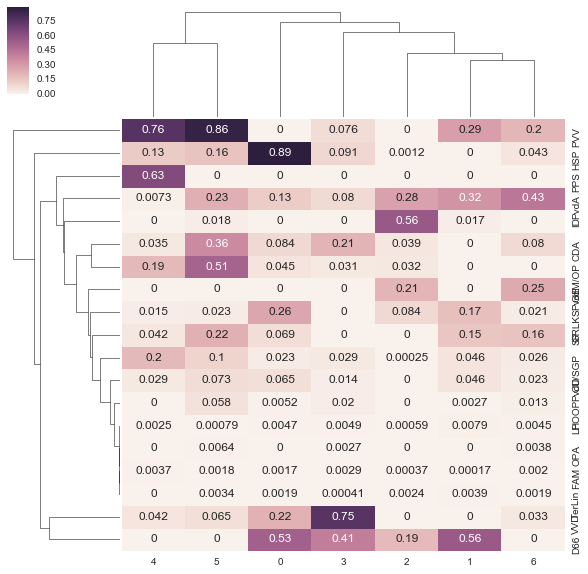

In [26]:
plt.figure(figsize = (16,10))
sns.clustermap(H_df_voting.T, annot = True)
plt.show()

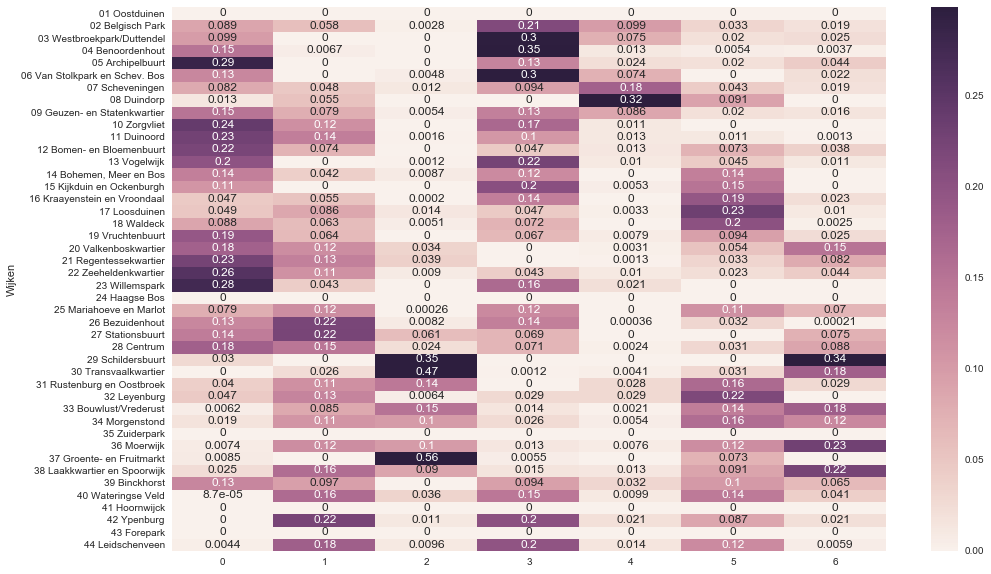

In [27]:
plt.figure(figsize = (16,10))
sns.heatmap(W_df_voting, robust = True ,annot = True)
plt.show()

## 6. Cluster districts based on voting profiles

In [28]:
# Gaussian mixture model
# H_df_voting = H_df_voting.T
# gmm2 = GaussianMixture(n_components=8).fit(H_df_voting)
# cluster = gmm2.predict(H_df_voting)
# H_df_voting['Cluster']= cluster
# H_df_voting

# K-means
# model = KMeans(n_clusters = 7)
# W_df_voting['Cluster'] = model.fit_predict(W_df_voting)

In [29]:
# Drop "irrelevant" districs
W_df_voting = W_df_voting.drop(['01 Oostduinen'])

# Predicting voting behavior

## I. Multiple linear regressioon

In [132]:
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn import metrics
X_train.shape, X_test.shape, X.shape


((34, 7), (9, 7), (43, 7))

In [138]:
# Define predictors and predictive variables
for i in range(7):
    X = W_df.iloc[:,:].values
    y = W_df_voting[i].values

    # Split X and y variables into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
    # X_train.shape, X_test.shape

    # Apply algorithm
    regressor = LinearRegression()
    regressor.fit(X_train, y_train)

    # Predict y
    y_pred = regressor.predict(X_test)

    print('Profile number : ',i)
    print('Intercept : ',regressor.intercept_)
    print('R-Squared : ',metrics.r2_score(y_test, y_pred))
    print('')


Profile number :  0
Intercept :  0.185313042073
R-Squared :  -0.107580277249

Profile number :  1
Intercept :  -0.0640459361224
R-Squared :  0.380844230472

Profile number :  2
Intercept :  0.513732155546
R-Squared :  0.850376915112

Profile number :  3
Intercept :  0.206187112041
R-Squared :  0.454740187292

Profile number :  4
Intercept :  -0.252776796588
R-Squared :  -0.900316680177

Profile number :  5
Intercept :  -0.263259107435
R-Squared :  -0.51876714306

Profile number :  6
Intercept :  -0.0740141384675
R-Squared :  0.544323158129



In [204]:
X_backward = np.append(arr = np.ones((43,1)).astype(int), values= X, axis=1)
X_opt = X_backward[:,[0,1,2]]
regressor_OLS = sm.OLS(endog = y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     53.94
Date:                Tue, 10 Apr 2018   Prob (F-statistic):           4.40e-12
Time:                        22:55:29   Log-Likelihood:                 77.945
No. Observations:                  43   AIC:                            -149.9
Df Residuals:                      40   BIC:                            -144.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0136      0.010      1.336      0.189      -0.007       0.034
x1            -0.0739      0.034     -2.175      0.036      -0.143      -0.005
x2             0.2237      0.022     10.328      0.000       0.180       0.267
==============================================================================
Omnibus:                        5.806   Durbin-Watson:                   2.457
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                7.660
Skew:                          -0.159   Prob(JB):                       0.0217
Kurtosis:                       5.043   Cond. No.                         5.82
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## II. SVR

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

In [ ]:
y = y.reshape(-1, 1)

In [ ]:
# ...
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)

In [ ]:
# Creating regressor
# The most important parameter is kernel. It defines what kind of kernel
# will be used, e.g. linear, polynomial, Gaussian, etc.
# rbf is non-linear kernel
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

In [ ]:
y_pred = regressor.predict(X)

In [ ]:
y

In [ ]:
y_pred

In [ ]:
# Predicting the Test set results
# To get the actual value of the predicted varaible it should
# be re-transformed back
y_pred = sc_y.inverse_transform(regressor.predict(sc_X.transform(np.array([[6.5]]))))

In [ ]:
# Visualising the SVR results (for higher resolution and smoother curve)
X_grid = np.arange(min(X), max(X), 0.01) # choice of 0.01 instead of 0.1 step because the data is feature scaled
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, regressor.predict(X_grid), color = 'blue')
# plt.title('Truth or Bluff (SVR)')
# plt.xlabel('Position level')
# plt.ylabel('Salary')
plt.show()

In [ ]:
plt.scatter(X, y, color = 'red')
plt.plot(X, regressor.predict(X), color = 'blue')
# plt.title('Truth of Bluff (SVR)')
# plt.xlabel('Postition level')
# plt.ylabel('Salary')
plt.show()